In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("dark")
import matplotlib.pyplot as plt
plt.grid()
import numpy as np

# Preprocessing v1

In [2]:
relation_df_train = pd.read_csv('../../new_data/Train/Relation/Relation.csv').drop(columns=['Unnamed: 0'])
relation_df_train.head()

,userid,like_id
0,c6a9a43058c8cc8398ca6e97324c0fae,8628204013
1,c6a9a43058c8cc8398ca6e97324c0fae,19040608370
2,c6a9a43058c8cc8398ca6e97324c0fae,24054583527
3,c6a9a43058c8cc8398ca6e97324c0fae,26726417043
4,c6a9a43058c8cc8398ca6e97324c0fae,31796936730


In [3]:
preprocessed_training_data = pd.DataFrame()

# Feature #1: How many likes a user has given on Facebook
like_counts_per_user = relation_df_train['userid'].value_counts()

# We will store our features in the preprocessed_training_data
preprocessed_training_data = preprocessed_training_data.assign(
    userid=like_counts_per_user.keys(),
    likes_given=like_counts_per_user.values
)

Text(0, 0.5, 'User count')

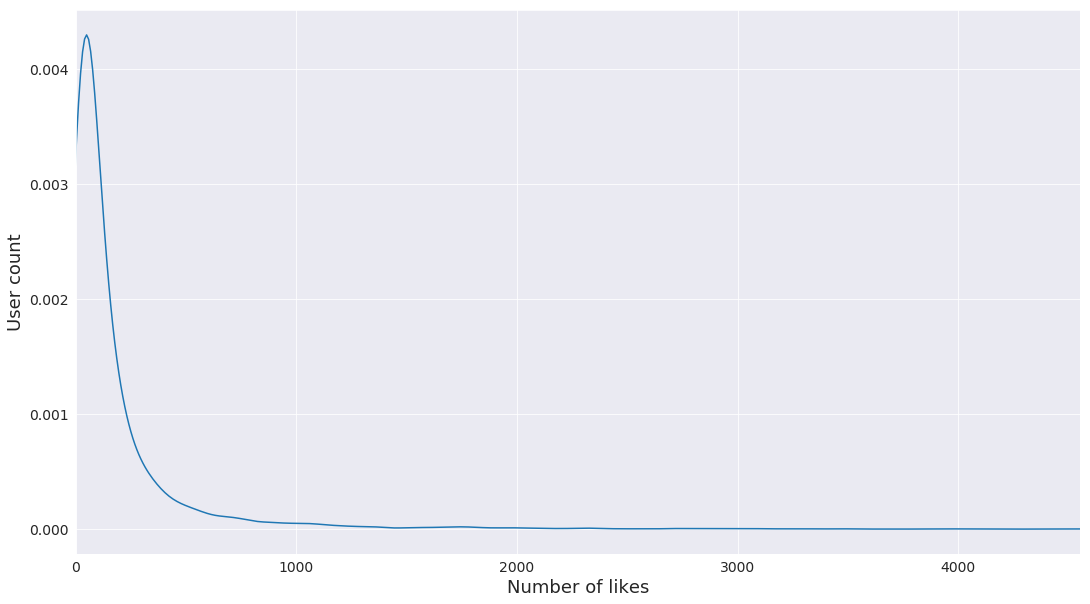

In [18]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax = preprocessed_training_data['likes_given'].plot.kde(legend=False)
ax.set_xlim(
    0,
    max(preprocessed_training_data['likes_given'])
)

plt.grid()



In [ ]:
preprocessed_training_data['likes_given'].describe()

In [ ]:
# Feature #2: The sum of the likes the pages the user liked have
#   For example, if the user liked the pages: x and y which have 13 and 12 likes respectively,
#   pages_liked_sum_likes = 25 for this user

like_counts_per_page = relation_df_train['like_id'].value_counts()

def get_userids(dataframe):
    return dataframe['userid']

def get_page_ids_liked_by_user(userid):
    return relation_df_train[relation_df_train['userid'] == userid]['like_id']

def get_page_total_likes(page_id):
    return like_counts_per_page[page_id]

# >15 minutes to run on the linux machine
preprocessed_training_data = preprocessed_training_data.assign(
    pages_liked_sum_likes=np.array([
        np.array([
            get_page_total_likes(page_id) for page_id in get_page_ids_liked_by_user(userid)
        ]).sum()
        for userid in get_userids(preprocessed_training_data)
    ])
)

In [ ]:
preprocessed_training_data

In [ ]:
# Let's normalise the fields to relative standard deviations instead:
preprocessed_training_data_std_distances = pd.DataFrame()
likes_given = {
    'mean': preprocessed_training_data.mean()['likes_given'],
    'std': preprocessed_training_data.std()['likes_given']
}
pages_liked_sum_likes = {
    'mean': preprocessed_training_data.mean()['pages_liked_sum_likes'],
    'std': preprocessed_training_data.std()['pages_liked_sum_likes']
}

preprocessed_training_data_z_scores = preprocessed_training_data_std_distances.assign(
    userid=preprocessed_training_data['userid'],
    likes_given_z_scores=(preprocessed_training_data['likes_given'] - likes_given['mean'])/likes_given['std'],
    pages_liked_sum_likes_z_scores=(preprocessed_training_data['pages_liked_sum_likes'] - pages_liked_sum_likes['mean'])/pages_liked_sum_likes['std']
)
preprocessed_training_data_z_scores

In [ ]:
# Saving the v1 preprocessed data for later
#preprocessed_training_data.to_csv('../../new_data/Train/Relation/relation_preprocessed_v1_raw.csv')
#preprocessed_training_data_z_scores.to_csv('../../new_data/Train/Relation/relation_preprocessed_v1_z_scores.csv')

In [19]:
#Loading the v1 preprocessed data
preprocessed_training_data_z_scores = pd.read_csv('../../new_data/Train/Relation/relation_preprocessed_v1_z_scores.csv').drop(columns=['Unnamed: 0'])

In [20]:
profile_df = pd.read_csv('../../new_data/Train/Profile/Profile.csv').drop(columns=['Unnamed: 0'])
merged_dataframe = profile_df.join(preprocessed_training_data_z_scores.set_index('userid'), on='userid')

In [21]:
merged_dataframe.head()

,userid,age,gender,ope,con,ext,agr,neu,likes_given_z_scores,pages_liked_sum_likes_z_scores
0,7267f43c71fcf53f4580fd3cd808bd48,26.0,0.0,4.00,2.25,2.20,3.60,2.80,-0.426495,-0.466681
1,e1cdac10d136e76e064e4860007d786d,24.0,0.0,4.20,3.35,2.45,3.90,2.60,-0.450534,-0.364914
2,ea4b8b534a35f59713f61f29b8725d09,27.0,1.0,2.75,4.80,3.15,3.85,4.15,0.201535,-0.246075
3,c7bb07b4b9ccd28cd0bc285194da5c72,29.0,1.0,3.40,3.20,2.10,3.70,2.35,-0.402455,-0.252654
4,e8b8f7f4f40ea6babfa9a2a967ff1866,25.0,0.0,4.40,3.25,4.00,2.89,2.35,-0.297283,-0.164170


In [34]:
def plot_correalation(x, y):
    plot = sns.lmplot(
        x,
        y,
        data=merged_dataframe[[x, y]],
        fit_reg=False,
        scatter_kws={'alpha': 0.6}
    )
    plt.grid()
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.subplots_adjust(top=0.9)
    plot.fig.suptitle(
        'Correalation between {} and {}'.format(x, y)
    )

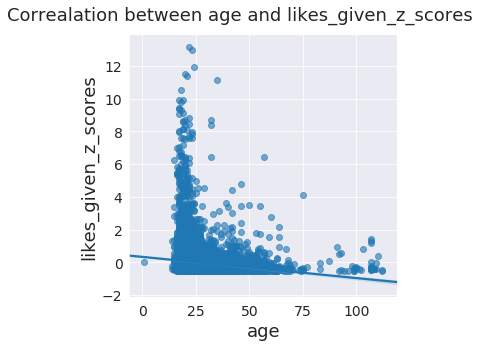

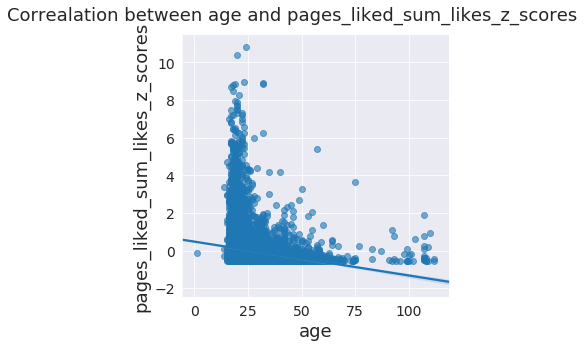

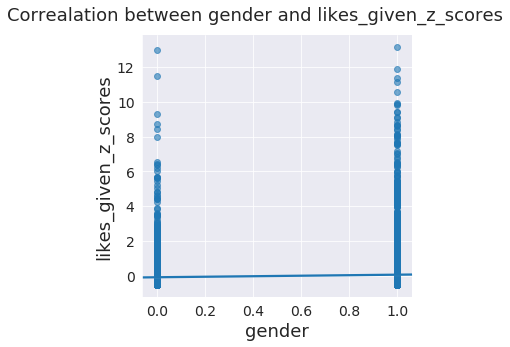

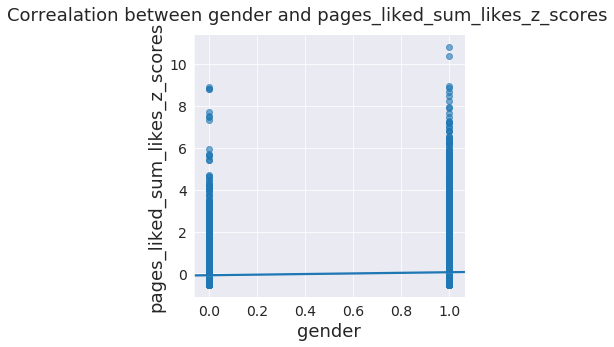

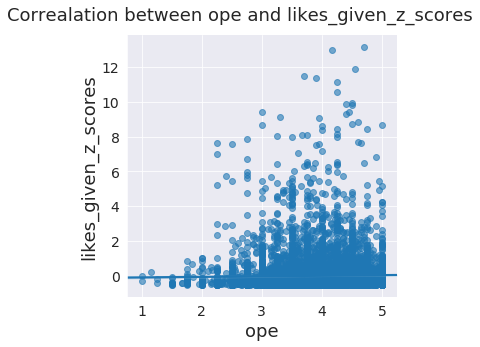

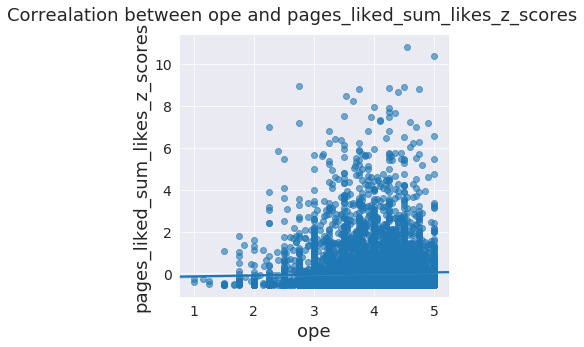

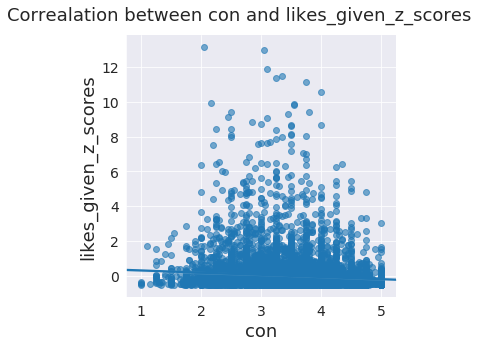

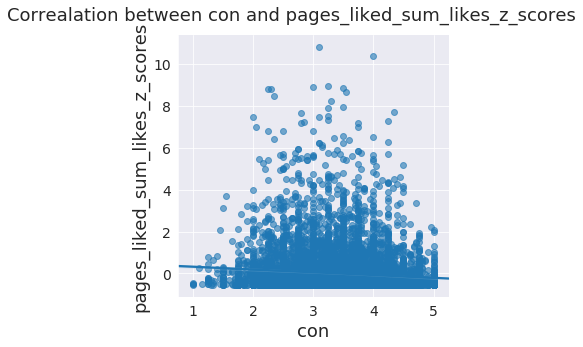

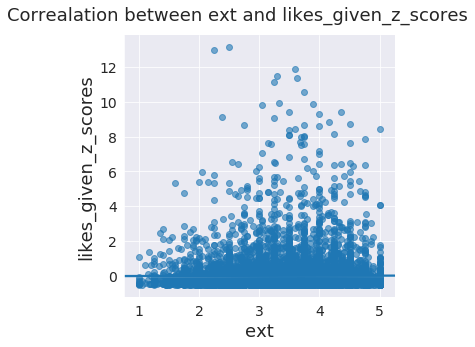

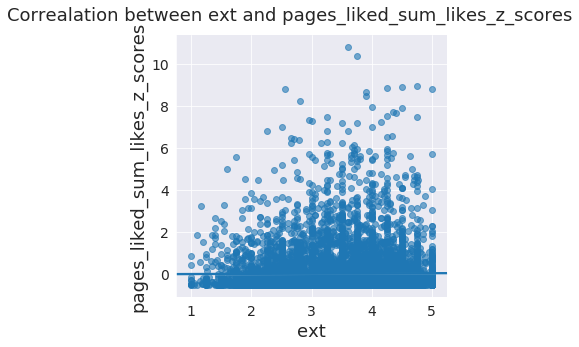

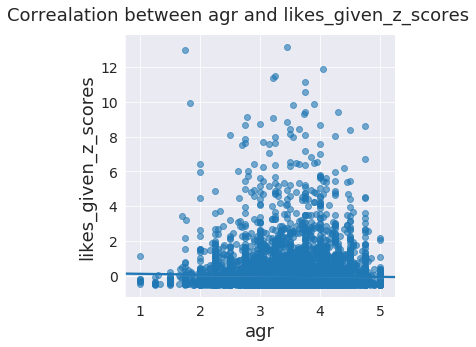

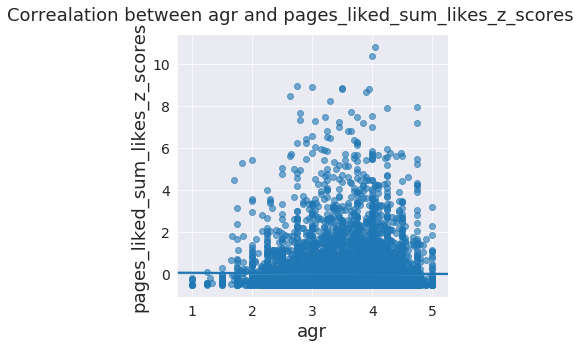

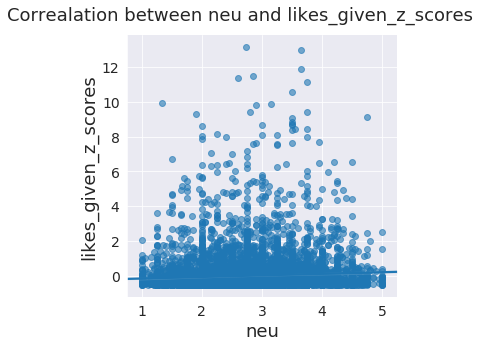

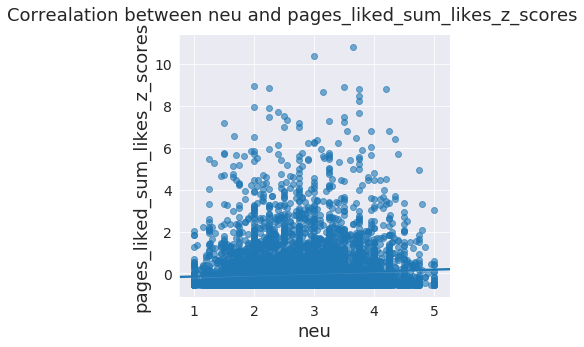

In [26]:
ys = ['likes_given_z_scores', 'pages_liked_sum_likes_z_scores']
xs = ['age', 'gender', 'ope', 'con', 'ext', 'agr', 'neu']

for x in xs:
    for y in ys:
        plot_correalation(x, y)

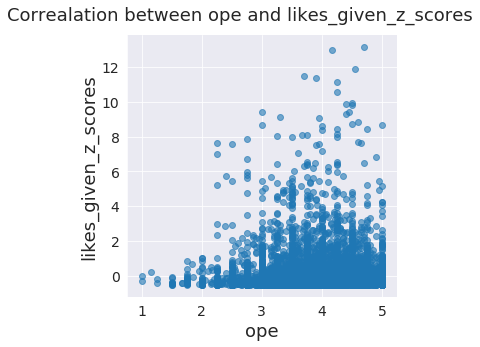

In [36]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_correalation("ope", "likes_given_z_scores")

Text(0.5, 15.439999999999984, 'Openness')

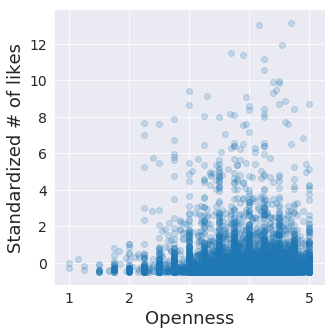

In [45]:
plt.rcParams['figure.figsize'] = [20, 15]
sns.lmplot(
        x="ope",
        y="likes_given_z_scores",
        data=merged_dataframe,
        fit_reg=False,
        scatter_kws={'alpha': 0.2}
    )
plt.grid()
plt.ylabel("Standardized # of likes")
plt.xlabel("Openness")
